Cleaning course data to be able to perform analysis on

In [52]:
!pip3 install wordcloud

2832.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 168 kB 1.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [69]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import plotly.express as px
from db.connection import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json


In [27]:
def clean_course(course):
    """
    Cleans a single course entry.
    """
    # Normalize text fields
    course["Course_Description"] = course.get("Course_Description", "").capitalize().strip()
    course["Course_Teacher"] = course.get("Course_Teacher", "").replace("Professor, ", "").strip()
    course["Course_Exam_Difficulty"] = course.get("Course_Exam_Difficulty", "").capitalize()
    course["Course_Required_Math_Level"] = course.get("Course_Required_Math_Level", "").replace("Very high", "High")
    
    # Convert numerical fields
    if "Course_Credit" in course:
        course["Course_Credit"] = int(course["Course_Credit"]) if course["Course_Credit"].isdigit() else None
    if "Course_Class_Hours" in course:
        course["Course_Class_Hours"] = int(course["Course_Class_Hours"]) if course["Course_Class_Hours"].isdigit() else None
    if "Homework_mandatorily required_hours" in course:
        course["Homework_mandatorily required_hours"] = int(course["Homework_mandatorily required_hours"]) if course["Homework_mandatorily required_hours"].isdigit() else None

    # Normalize boolean fields
    if "With_Course_Videos" in course:
        course["With_Course_Videos"] = course["With_Course_Videos"].lower() == "yes"
    
    # Return cleaned course
    return course

def clean_courses(file_path, output_path):
    """
    Reads a JSON file with courses, cleans each course, and saves the cleaned data to a new file.
    """
    try:
        # Load the JSON file
        with open(file_path, "r", encoding="utf-8") as file:
            courses = json.load(file)
        
        # Clean each course
        cleaned_courses = [clean_course(course) for course in courses]

        # Save the cleaned courses to a new file
        with open(output_path, "w", encoding="utf-8") as file:
            json.dump(cleaned_courses, file, indent=4, ensure_ascii=False)

        print(f"Cleaned courses saved to {output_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [28]:
#clean courses
input_file = 'model/files/courses.json'
output_file = 'model/files/cleaned_courses.json'
processed_file = 'model/files/processed_courses.json'

clean_courses(input_file, output_file)


An error occurred: 'int' object has no attribute 'isdigit'


In [29]:
#feature engineering

def extract_course_concepts(courses, num_concepts=20):
    """
    Extracts top keywords from course descriptions using TF-IDF.
    """
    descriptions = [course["Course_Description"] for course in courses]

    # Apply TF-IDF vectorization
    vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(descriptions)
    feature_names = vectorizer.get_feature_names_out()

    # Extract top keywords for each course
    for i, course in enumerate(courses):
        tfidf_scores = tfidf_matrix[i].toarray()[0]
        top_indices = tfidf_scores.argsort()[-num_concepts:][::-1]
        top_concepts = [feature_names[idx] for idx in top_indices]
        course["Extracted_Concepts"] = top_concepts

    return courses

def encode_categorical_features(courses, categorical_fields, ordinal_cat_fields):
    """
    Encodes categorical features as sets for Jaccard similarity.
    """
    # One-hot encode categorical variables
    encoder = OneHotEncoder()
    ordinal_encoder = OrdinalEncoder()
   
    categorical_data = pd.DataFrame(courses)[categorical_fields]
    ordinal_cat_data = pd.DataFrame(courses)[ordinal_cat_fields]
    encoded_features = encoder.fit_transform(categorical_data)
    ordinal_encoded_features = ordinal_encoder.fit_transform(ordinal_cat_data)

    # Update courses with scaled values
    for i, course in enumerate(courses):
        for j, field in enumerate(categorical_fields):
            course[field] = encoded_features[i, j]
        for j, field in enumerate(ordinal_cat_fields):
            course[field] = ordinal_encoded_features[i, j]
    return courses

def scale_numerical_features(courses, numerical_fields):
    """
    Scales numerical features using Min-Max Scaling.
    """
    scaler = MinMaxScaler()
    numerical_data = pd.DataFrame(courses)[numerical_fields]
    scaled_data = scaler.fit_transform(numerical_data)

    # Update courses with scaled values
    for i, course in enumerate(courses):
        for j, field in enumerate(numerical_fields):
            course[field] = scaled_data[i, j]
    return courses

def convert_sets_to_lists(courses):
    """
    Converts all sets in the course data to lists for JSON serialization.
    """
    for course in courses:
        for key, value in course.items():
            if isinstance(value, set):
                course[key] = list(value)
    return courses


def feature_engineering_pipeline(courses):
    """
    Full feature engineering pipeline for courses.
    """
    # Step 1: Extract course concepts
    courses = extract_course_concepts(courses)

    # Step 2: Encode categorical features
    categorical_fields = ["Course_Teaching_Style", "Course_Exam_Type", "Course_Module", 'Course_Language']
    ordinal_cat_fields = ["Course_Exam_Difficulty", "Course_Required_Math_Level"]
    courses = encode_categorical_features(courses, categorical_fields, ordinal_cat_fields)

    # # Step 3: Scale numerical features
    numerical_fields = ["Course_Credit", "Course_Class_Hours", "Homework_mandatorily required_hours"]
    courses = scale_numerical_features(courses, numerical_fields)

    return courses



In [ ]:
#feature engineering and storing courses in diff file
# Load cleaned data
with open(processed_file, "r", encoding="utf-8") as file:
    courses = json.load(file)

# Apply feature engineering pipeline
processed_courses = feature_engineering_pipeline(courses)

# Convert sets to lists for JSON compatibility
processed_courses = convert_sets_to_lists(processed_courses)

# Save processed data
with open("files/processed_courses.json", "w", encoding="utf-8") as file:
    json.dump(processed_courses, file, indent=4, ensure_ascii=False)

print("Feature engineering completed and saved!")


In [ ]:

# Load JSON data from a file
with open(processed_courses, 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
df = pd.json_normalize(data)

# Set the index to course id
df.set_index('Course_ID', inplace=True)

# Display the first 5 records
print(df.head())

In [100]:
# Load JSON data from a file
with open(input_file, 'r') as file:
    data = json.load(file)

with open(processed_file, 'r') as file:
    processed_data = json.load(file)

# Replace extracted concepts in 'processed_data' with core concepts from 'data'
for course in processed_data:
    # Find the corresponding entry from 'data' by matching course id
    entry = next((item for item in data if item['Course_ID'] == course['Course_ID']), None)
    
    # If a matching entry is found, update the 'Extracted_Concepts'
    if entry:
        course['Extracted_Concepts'] = entry['Course_Core_Concept']


# Save the updated 'processed_data' to a file
with open(processed_file, "w", encoding="utf-8") as file:
    json.dump(processed_data, file, indent=4)



In [67]:
# fetch dataa
courses_data = fetch_data('processed_courses')

df = pd.DataFrame(courses_data)

print(df.head(1))

Pinged your deployment. You successfully connected to MongoDB!
                        _id Course_ID               Course_Name  \
0  67755b588cd78ea1d39b7a3d  ZKD50032  Advanced Image Synthesis   

                                  Course_Description            Term  \
0  Abstract:\nThis lecture covers the fundamental...  Winter 2024/25   

   Course_Language              Course_Teacher  Course_Credit  \
0                0  Professor, Dr. Jens Krüger              0   

   With_Course_Videos  Course_Teaching_Style  ...  Course_Exam_Type  \
0                True                      1  ...                 0   

   Course_Required_Math_Level  Course_Recommended_Background  \
0                           4            [Computer graphics]   

                       Programming_Requirements Course_Class_Hours  \
0  [{'Language': 'C++', 'Level': 'proficient'}]                0.5   

   Homework_mandatorily required_hours  Course_Module  \
0                                  0.0              0   

In [99]:
# One-hot encoding concepts
df = pd.DataFrame(courses_data)

df["Extracted_Concepts"] = df["Extracted_Concepts"].apply(lambda x: ",".join(x))  # Join list of concepts into a string
concepts_array = df[["Extracted_Concepts"]]  # Convert to DataFrame with single column

encoder = OneHotEncoder()
concept_matrix = encoder.fit_transform(concepts_array).toarray()

# Reduce dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(concept_matrix)

# Create a DataFrame
df_reduced = pd.DataFrame(reduced_data, columns=["x", "y"])
df_reduced["Course_ID"] = df["Course_ID"]

# Plot clustering
fig = px.scatter(
    df_reduced, 
    x="x", 
    y="y", 
    text="Course_ID",
    size_max=200,
    title="Course Clustering based on Extracted Concepts"
)


# Update the font size specifically for the text labels
fig.update_traces(
    textfont=dict(
        family="Courier New, monospace",
        size=7,  # Set the desired font size
        color="red"  # Optional: Change text color
    ),
    marker=dict(size=10)
)

fig.show()


In [ ]:
# Create DataFrame
df = pd.DataFrame(courses_data)
# print(df.count())

# Bubble chart
fig = px.scatter(
    df, 
    x="Course_Exam_Difficulty", 
    y="Course_Credit", 
    size="Course_Class_Hours", 
    color="Course_Module",
    title="Module Comparison: Credits vs Difficulty"
)
fig.show()

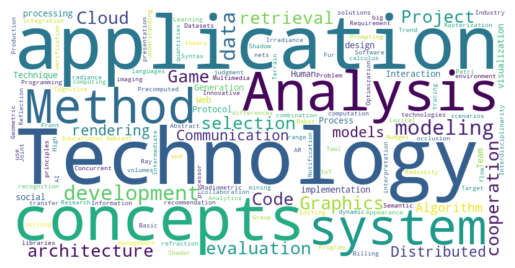

In [56]:

#word cloud
concepts = []
all = []

for course in courses_data:
    concepts.append(course['Extracted_Concepts'])

flattened_concepts = [", ".join(course) for course in concepts]

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(flattened_concepts))

# Display with matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [57]:
fig = px.bar(df, x="Course_Teacher", title="Number of Courses by Teacher")
fig.show()

In [114]:
fig = px.pie(df, values='Course_Module', names='Course_Module', title='Distribution of Courses by Modules')
fig.show()